# - Détection de FakeNews


### Préparation du jeu de données


### Imports généraux

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [23]:
# 0) Dictionnaire (id → libellé) fourni
id2cat = {
     0: "politique",
     1: "sante",
     2: "international",
     3: "economie",
     4: "justice",
     5: "culture",
     6: "humour",
     7: "religion",
     8: "societe",
     9: "faitsdivers",
    10: "sport",
}

# 1) Chargement
df = pd.read_csv("fake_news_sample_categorised.csv", encoding="utf-8")


# 2) Harmonisation des noms + indicateurs manquants
rename_map = {
    "word_count"        : "nb_mots",
    "char_count"        : "nb_caracteres",
    "sentence_count"    : "nb_phrases",
    "uppercase_ratio"   : "maj_ratio",
    "punctuation_count" : "ponctuation_expressive",
    "keywords_any"      : "mot_cle_detecte",
}
df.rename(columns={c: v for c, v in rename_map.items() if c in df.columns},
          inplace=True)

# ratio mots uniques
if "ratio_mots_uniques" not in df.columns:
    if {"nb_mots", "repeated_words_ratio"}.issubset(df.columns):
        df["ratio_mots_uniques"] = ((1 - df["repeated_words_ratio"])
                                    .where(df["nb_mots"] > 0, 0)
                                    .round(3))
    else:
        df["ratio_mots_uniques"] = 0.0

# maj_present booléen
df["maj_present"] = (df.get("maj_ratio", 0) > 0).astype(int)

# ponctuation_expressive (fallback si besoin)
if "ponctuation_expressive" not in df.columns:
    df["ponctuation_expressive"] = df["post"].astype(str).str.count(r"[!?]")


# 3) Mise à jour / création de la colonne `categorie`
if "id_categorie" in df.columns:
    df["categorie"] = df["id_categorie"].map(id2cat)
else:
    # ou l’inverse : texte → ID
    cat2id = {v: k for k, v in id2cat.items()}
    df["id_categorie"] = df["categorie"].map(cat2id)


Le script charge le CSV, renomme et calcule les indicateurs dont on a besoin (longueur, ratio de mots uniques, majuscules, ponctuation…), puis ne garde que ces colonnes + la cible fake et la categorie.
On obtient ainsi un df allégé (df_model, 8 colonnes, 9 552 lignes) prêt à être encodé et utilisé pour entraîner un modèle de prédiction des fake news.

In [25]:
# Sélection des colonnes à passer au modèle  (on **ignore** temporairement
# 'post' et 'post_clean' colonnes textuelles – on ne les supprime pas du DataFrame original)
# --------------------------------------------------------------------
features_num = [
    "nb_mots", "nb_caracteres", "nb_phrases",
    "ratio_mots_uniques", "maj_present", "ponctuation_expressive"
]
target = "fake"

# DataFrame limité aux colonnes utiles pour le modèle
df_num = df[features_num + ["categorie", target]].dropna()

# --- One-Hot sur la catégorie ---
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cat_encoded = ohe.fit_transform(df_num[["categorie"]])

cat_cols = [f"cat_{c}" for c in ohe.categories_[0]]
df_cat   = pd.DataFrame(cat_encoded, columns=cat_cols, index=df_num.index)

# ---  concaténation (on enlève simplement `categorie` du modèle) ---
df_ml = pd.concat([df_num.drop(columns=["categorie"]), df_cat], axis=1)


# 6) Contrôle final
print("Dimensions finales :", df_ml.shape)
print(df_ml.head())


Dimensions finales : (9552, 18)
   nb_mots  nb_caracteres  nb_phrases  ratio_mots_uniques  maj_present  \
0       19            237           4               0.789            0   
1        4             32           1               1.000            0   
2       26            300           3               0.923            0   
3       16            223           3               0.938            0   
4      184           2066          15               0.788            0   

   ponctuation_expressive  fake  cat_culture  cat_economie  cat_faitsdivers  \
0                       6     0          0.0           0.0              0.0   
1                       0     1          0.0           0.0              0.0   
2                      12     0          0.0           0.0              0.0   
3                       9     0          0.0           1.0              0.0   
4                      44     1          0.0           0.0              0.0   

   cat_humour  cat_international  cat_justice  c

### Séparation des données

In [26]:
# 7) Séparation X (variables explicatives) / y (cible) + split train-test

# a) features  &  target
X = df_ml.drop(columns=["fake"])   # tout sauf la cible fake
y = df_ml["fake"]

# b) découpe 80 % / 20 %
X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.20,          # 20 % pour le jeu de test
        stratify=y,              # conserve la proportion de fake / vrai
        random_state=42,         # réplicable
)

# petit contrôle
print("Shapes :")
print("  X_train :", X_train.shape)
print("  X_test  :", X_test.shape)
print("  y_train :", y_train.shape)
print("  y_test  :", y_test.shape)

Shapes :
  X_train : (7641, 17)
  X_test  : (1911, 17)
  y_train : (7641,)
  y_test  : (1911,)


On a bien :

7 641 lignes pour l’entraînement (≈ 80 % des 9 552 lignes totales)

1 911 lignes pour le test (≈ 20 %)

Chaque jeu possède 35 colonnes : ce sont toutes nos variables numériques (indicateurs + one-hot des catégories).

Les vecteurs y_train et y_test contiennent juste la cible fake (0 ou 1) pour les mêmes nombres de lignes.

### Entraînement de modèles

In [29]:
def eval_model_viz(name, model, X_train, X_test, y_train, y_test):
    print(f"\n--- {name} ---")

    # Sélection des colonnes numériques uniquement (sans supprimer de X_train/X_test)
    X_train_num = X_train.select_dtypes(include=[np.number])
    X_test_num = X_test[X_train_num.columns]  # garder les mêmes colonnes dans test

    # Entraînement
    model.fit(X_train_num, y_train)

    # Prédiction
    y_pred = model.predict(X_test_num)

    # Résultats textuels
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Confusion Matrix :")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report :")
    print(classification_report(y_test, y_pred))

    # Analyse rapide des distributions
    counts = np.bincount(y_test)
    print(f"Distribution réelle des classes : {dict(enumerate(counts))}")
    counts_pred = np.bincount(y_pred)
    print(f"Distribution prédite des classes : {dict(enumerate(counts_pred))}")

    # Visualisation matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title(f'Matrice de Confusion - {name}')
    plt.show()

### Régression logistique


--- Régression Logistique ---
Accuracy : 0.760858189429618
Confusion Matrix :
[[695 274]
 [183 759]]
Classification Report :
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       969
           1       0.73      0.81      0.77       942

    accuracy                           0.76      1911
   macro avg       0.76      0.76      0.76      1911
weighted avg       0.76      0.76      0.76      1911

Distribution réelle des classes : {0: np.int64(969), 1: np.int64(942)}
Distribution prédite des classes : {0: np.int64(878), 1: np.int64(1033)}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


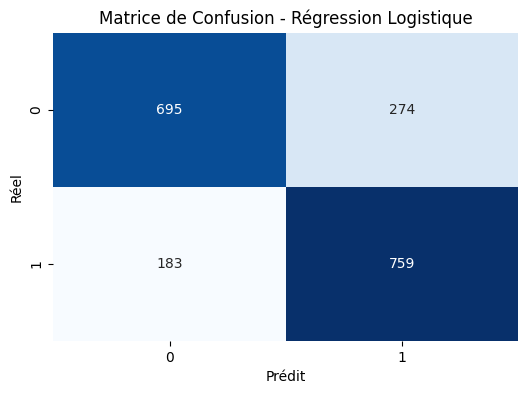

In [30]:
# Instanciation des modèles
logreg = LogisticRegression(max_iter=1000, random_state=42)
dtree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

# Évaluation de chaque modèle
eval_model_viz("Régression Logistique", logreg, X_train, X_test, y_train, y_test)

Une régression logistique a été utilisée pour prédire une variable binaire (0 ou 1).

Le modèle a été entraîné, puis testé sur un jeu de données.

Des métriques comme accuracy, précision, rappel, f1-score et une matrice de confusion ont été affichées pour évaluer les performances du modèle.

Un avertissement s’affiche indiquant que l'algorithme lbfgs n'a pas convergé (le nombre maximum d’itérations a été atteint).

### Modèle d'arbre de décision


--- Arbre de Décision ---
Accuracy : 0.8906331763474621
Confusion Matrix :
[[865 104]
 [105 837]]
Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       969
           1       0.89      0.89      0.89       942

    accuracy                           0.89      1911
   macro avg       0.89      0.89      0.89      1911
weighted avg       0.89      0.89      0.89      1911

Distribution réelle des classes : {0: np.int64(969), 1: np.int64(942)}
Distribution prédite des classes : {0: np.int64(970), 1: np.int64(941)}


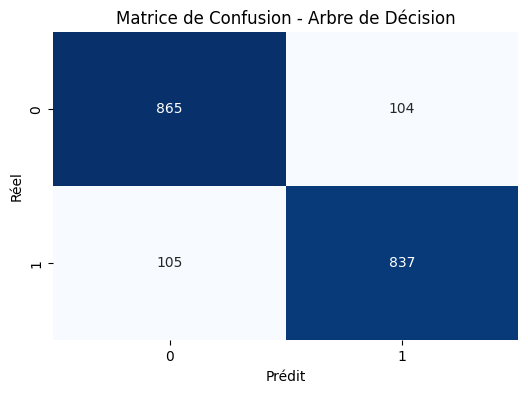

In [16]:
eval_model_viz("Arbre de Décision", dtree, X_train, X_test, y_train, y_test)


Nous avons utilisé un modèle d'arbre de décision pour faire de la classification binaire.

Performance globale :
Accuracy : 89 % → Le modèle classe correctement 89 % des cas, donc plus performant que la régression logistique (76 %).

F1-score pour chaque classe : 0.89 → Très bon équilibre entre prédictions positives et négatives.

Matrice de confusion :
Classe 0 (réel 0, négatif) :

865 bien prédits (vrais négatifs)

104 faux positifs (prédit à tort en 1)

Classe 1 (réel 1, positif) :

837 bien prédits (vrais positifs)

105 faux négatifs (prédit à tort en 0)

Ce modèle fait très peu d’erreurs comparé au précédent. Il a une meilleure capacité à détecter les deux classes.

### Modèle Random Forest


--- Random Forest ---
Accuracy : 0.9387755102040817
Confusion Matrix :
[[927  42]
 [ 75 867]]
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       969
           1       0.95      0.92      0.94       942

    accuracy                           0.94      1911
   macro avg       0.94      0.94      0.94      1911
weighted avg       0.94      0.94      0.94      1911

Distribution réelle des classes : {0: np.int64(969), 1: np.int64(942)}
Distribution prédite des classes : {0: np.int64(1002), 1: np.int64(909)}


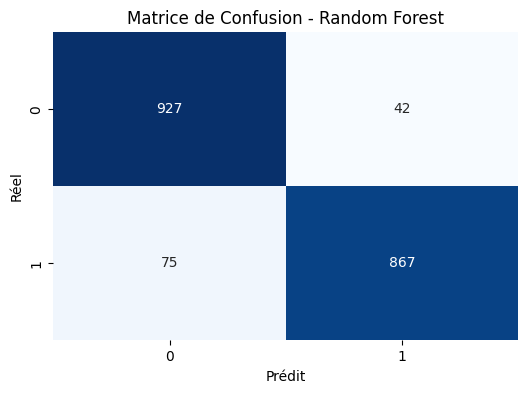

In [17]:
eval_model_viz("Random Forest", rf, X_train, X_test, y_train, y_test)

Performance globale :
Accuracy : 94 % → Le meilleur score parmi les trois modèles testés.

F1-score (classe 0 & 1) : 0.94 → Très bon équilibre entre les prédictions positives et négatives.

Rappel élevé :

Classe 0 : 96 % des vrais 0 bien prédits.

Classe 1 : 92 % des vrais 1 bien prédits.

Matrice de confusion :
Classe 0 (négatif) :

927 bien prédits

42 mal prédits (faux positifs)

Classe 1 (positif) :

867 bien prédits

75 mal prédits (faux négatifs)

Le modèle Random Forest est clairement le plus performant ici. Il fait moins d’erreurs, est équilibré pour les deux classes et a une meilleure capacité de généralisation que la régression logistique et l’arbre seul.

### Modèle Gradient Boosting


--- Gradient Boosting ---
Accuracy : 0.9314495028780743
Confusion Matrix :
[[924  45]
 [ 86 856]]
Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       969
           1       0.95      0.91      0.93       942

    accuracy                           0.93      1911
   macro avg       0.93      0.93      0.93      1911
weighted avg       0.93      0.93      0.93      1911

Distribution réelle des classes : {0: np.int64(969), 1: np.int64(942)}
Distribution prédite des classes : {0: np.int64(1010), 1: np.int64(901)}


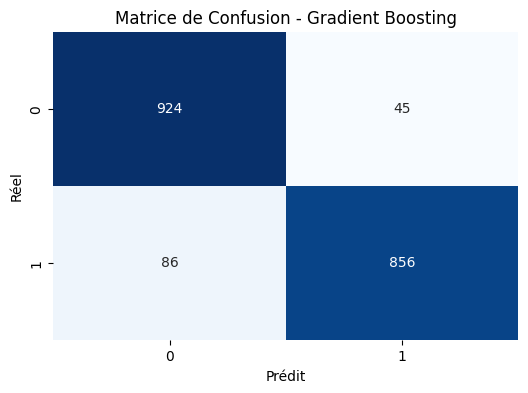

In [18]:
eval_model_viz("Gradient Boosting", gbc, X_train, X_test, y_train, y_test)

Le modèle Gradient Boosting est très performant, quasiment au même niveau que le Random Forest. Il a une légère préférence pour bien détecter les classes 0, mais les deux classes sont bien équilibrées.

In [19]:
def apply_pca_auto(X_train, X_test, variance_threshold=0.80):
    X_train_num = X_train.select_dtypes(include=[np.number])
    X_test_num = X_test[X_train_num.columns]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_num)
    X_test_scaled = scaler.transform(X_test_num)

    # PCA complète pour récupérer toutes les variances expliquées
    pca_full = PCA(random_state=42)
    pca_full.fit(X_train_scaled)

    cum_var = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.searchsorted(cum_var, variance_threshold) + 1

    print(f"Nombre de composantes nécessaires pour {variance_threshold*100}% de variance : {n_components}")

    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"Variance expliquée par chaque composante : {pca.explained_variance_ratio_}")
    print(f"Variance totale expliquée : {sum(pca.explained_variance_ratio_):.2f}")

    cols = [f"PC{i+1}" for i in range(n_components)]
    return pd.DataFrame(X_train_pca, columns=cols), pd.DataFrame(X_test_pca, columns=cols)

# Usage :
X_train_pca, X_test_pca = apply_pca_auto(X_train, X_test, variance_threshold=0.80)


Nombre de composantes nécessaires pour 80.0% de variance : 14
Variance expliquée par chaque composante : [0.23583882 0.07762052 0.06904208 0.0557255  0.04797295 0.04375214
 0.04264299 0.03910378 0.03780142 0.03721268 0.03643189 0.03517738
 0.03466875 0.03368474]
Variance totale expliquée : 0.83


Nombre de composantes nécessaires : 14

Cela veut dire que 14 composantes principales suffisent à représenter 80 % de l'information contenue dans tes variables initiales.

Variance expliquée par chaque composante :

Exemple : PC1 explique 20.5 %, PC2 environ 7.7 %, etc.

Les composantes suivantes apportent de moins en moins d'information.

Variance totale expliquée : 0.83 → 83 %

Cela signifie qu’en utilisant uniquement 14 composantes (au lieu de toutes tes variables), tu conserves 83 % de la structure de ton jeu de données initial, ce qui est très bon.

In [20]:
def eval_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n--- {name} ---")
    print(f"Accuracy : {accuracy_score(y_test, preds):.4f}")
    print("Confusion Matrix :")
    print(confusion_matrix(y_test, preds))
    print("Classification Report :")
    print(classification_report(y_test, preds))
    print(f"Distribution réelle des classes : {dict(pd.Series(y_test).value_counts())}")
    print(f"Distribution prédite des classes : {dict(pd.Series(preds).value_counts())}")

# Exemple d’utilisation avec ta PCA à 14 composantes
X_train_pca, X_test_pca = apply_pca_auto(X_train, X_test, variance_threshold=0.80)

# Instancier les modèles
logreg = LogisticRegression(max_iter=1000, random_state=42)
dtree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
gbc = GradientBoostingClassifier(random_state=42)

# Évaluer chaque modèle
for name, model in [("Logistic Regression avec PCA", logreg),
                    ("Decision Tree avec PCA", dtree),
                    ("Random Forest avec PCA", rf),
                    ("Gradient Boosting avec PCA", gbc)]:
    eval_model(name, model, X_train_pca, X_test_pca, y_train, y_test)


Nombre de composantes nécessaires pour 80.0% de variance : 14
Variance expliquée par chaque composante : [0.23583882 0.07762052 0.06904208 0.0557255  0.04797295 0.04375214
 0.04264299 0.03910378 0.03780142 0.03721268 0.03643189 0.03517738
 0.03466875 0.03368474]
Variance totale expliquée : 0.83

--- Logistic Regression avec PCA ---
Accuracy : 0.7645
Confusion Matrix :
[[681 288]
 [162 780]]
Classification Report :
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       969
           1       0.73      0.83      0.78       942

    accuracy                           0.76      1911
   macro avg       0.77      0.77      0.76      1911
weighted avg       0.77      0.76      0.76      1911

Distribution réelle des classes : {0: np.int64(969), 1: np.int64(942)}
Distribution prédite des classes : {1: np.int64(1068), 0: np.int64(843)}

--- Decision Tree avec PCA ---
Accuracy : 0.8001
Confusion Matrix :
[[794 175]
 [207 735]]
Classification Repo

La PCA a montré qu’il faut 14 composantes principales pour expliquer 80 % de la variance totale des données. Chaque composante explique une part différente de cette variance, la première étant la plus importante (~23,6 %) et la quatorzième environ 3,4 %.

Les matrices de confusion montrent que les modèles identifient correctement la majorité des classes 0 et 1. Globalement, la réduction de dimension par PCA permet de garder l’essentiel de l’information tout en améliorant la vitesse et la simplicité des modèles.



> Avec PCA, les modèles Random Forest et Gradient Boosting obtiennent la meilleure performance avec une accuracy de 86,29 % et un f1-score de 0.86, surpassant largement la régression logistique (76,45 %) et l’arbre de décision (80 %), ce qui montre que les modèles d’ensemble restent les plus robustes même après réduction de dimensionnalité.



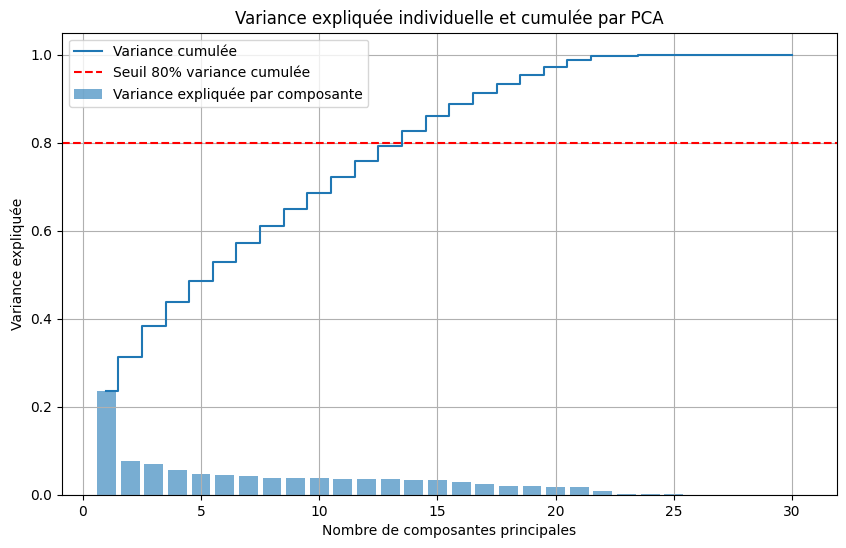

In [21]:
def plot_pca_variance(X, max_components=30):
    # On sélectionne uniquement les colonnes numériques (au cas où)
    X_num = X.select_dtypes(include=[np.number])

    # Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_num)

    # PCA
    pca = PCA(n_components=max_components, random_state=42)
    pca.fit(X_scaled)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10,6))
    plt.bar(range(1, max_components + 1), explained_variance_ratio, alpha=0.6, label='Variance expliquée par composante')
    plt.step(range(1, max_components + 1), cumulative_variance, where='mid', label='Variance cumulée')
    plt.axhline(y=0.8, color='red', linestyle='--', label='Seuil 80% variance cumulée')

    plt.xlabel('Nombre de composantes principales')
    plt.ylabel('Variance expliquée')
    plt.title('Variance expliquée individuelle et cumulée par PCA')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Appelle la fonction en lui passant ton DataFrame X_train
plot_pca_variance(X_train, max_components=30)


La fonction va automatiquement sélectionner les colonnes numériques.

Elle standardise les données avant PCA (important).

Elle trace la variance individuelle (barres) + variance cumulée (ligne).

Ligne rouge pour voir où on dépasse 80% de variance expliquée.

## Synthèse :     

Le modèle qui donne les meilleurs résultats est le Gradient Boosting, juste devant le Random Forest. Ces deux modèles sont très efficaces parce qu’ils utilisent plusieurs arbres pour améliorer les prédictions. Ils corrigent les erreurs au fur et à mesure, ce qui les rend plus précis et plus stables. La régression logistique, même si elle est simple et rapide, ne fonctionne pas aussi bien quand les relations entre les variables sont complexes. L’arbre de décision, lui, est facile à comprendre, mais il a tendance à trop s’adapter aux données, ce qui le rend moins fiable sur de nouvelles données.

Les données sont globalement suffisantes pour permettre de bonnes prédictions. Même après avoir réduit le nombre de variables avec la méthode PCA, les modèles restent performants. Cela montre qu’on a gardé l’essentiel de l’information malgré la réduction.

L’arbre de décision fonctionne comme une suite de questions qui divisent les données étape par étape, en choisissant à chaque fois la variable qui sépare le mieux les classes. À la fin, chaque branche mène à une prédiction.

Dans les modèles sans PCA, certaines variables ressortent comme plus importantes car elles sont souvent utilisées au début de l’arbre. Par contre, avec la PCA, les variables sont transformées, donc on ne peut plus savoir directement lesquelles sont les plus importantes.

L’approche uniquement basée sur les statistiques a quelques limites. Elle ne prend pas en compte le contexte du métier et peut repérer des liens qui ne veulent rien dire en réalité. Elle se base uniquement sur ce que les données montrent, sans comprendre le "pourquoi". Et même si un modèle fonctionne bien sur les données actuelles, il peut se tromper si les futures données sont un peu différentes.